In [1]:

import matplotlib.pyplot as plt
import numpy as np
import os
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1.5
fsize=12
plt.rcParams.update({'font.size': 12})
import cartopy.feature as cfeature

def plot_uv_map(uv,lon2D,lat2D,cmap=plt.cm.RdBu_r,vmax=1,vmin=-1,title=None,colorbar_title="norm(U) [m/s]",axs=None,fig=None,colorbar=True,lat_mask=None):

    #proj = ccrs.Robinson()

    if not axs:

        fig, axs = plt.subplots(nrows=1,ncols=1,
                            subplot_kw={'projection': ccrs.Robinson()},
                            figsize=(11*1,5*1))

    """
    axs.add_feature(
    cfeature.LAND,
    facecolor='lightgray',  # Couleur de remplissage
    edgecolor='black',      # Couleur des bordures (optionnel)
    zorder=2                # Ordre de dessin (0 = en arrière-plan)
    )
    """
    import cartopy
    # projection = cartopy.crs.Mercator()
    axs.add_feature(cartopy.feature.LAND, zorder=3)
    axs.add_feature(cartopy.feature.COASTLINE, zorder=3)
    axs.add_feature(cartopy.feature.LAKES, alpha=0.5, zorder=3)
    axs.add_feature(cartopy.feature.RIVERS, zorder=3)
    
    for spine in axs.spines.values():
        spine.set_zorder(11)  # zorder élevé pour que les bords soient au-dessus des autres éléments


    if lat_mask is not None:
        axs.hlines(lat_mask,np.min(lon2D),np.max(lon2D),color='k', alpha=1, linestyle='--',transform=ccrs.PlateCarree())
        axs.hlines(-lat_mask,np.min(lon2D),np.max(lon2D),color='k', alpha=1, linestyle='--',transform=ccrs.PlateCarree())

    if title:
        axs.set_title(title)

    #p0 = plt.pcolormesh(lon2D, lat2D, norm_uv, cmap='jet',vmax=1)
    p0 = axs.pcolormesh(lon2D, lat2D, uv, cmap=cmap,vmax=vmax,vmin=vmin,transform=ccrs.PlateCarree())  

    axs.coastlines(resolution='10m', lw=0.5)
    #axs.add_feature(cfeature.LAND.with_scale('50m'), facecolor='#EEEEEE', edgecolor='face',alpha=1)

    # optional add grid lines
    p0.axes.gridlines(color='k', alpha=0.2, linestyle='--', linewidth=1,zorder=10)

    # optional add grid lines
    #p0.axes.gridlines(color='black', alpha=0., linestyle='--')

    # draw parallels/meridiens and write labels
    gl = p0.axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                            linewidth=0.2, color='black', alpha=0.8, linestyle='--')
    # adjust labels to taste
    gl.top_labels = False
    gl.right_labels = False
    gl.bottom_labels = True
    gl.left_labels = True
    #gl.ylocator = mticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])
    #gl.xlocator = mticker.FixedLocator([-180, -60, 0,  60, 180])
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}

    #get size and extent of axes:
    axpos = axs.get_position()
    pos_x = axpos.x0+axpos.width + 0.01# + 0.25*axpos.width
    pos_y = axpos.y0
    cax_width = 0.02
    cax_height = axpos.height

    if colorbar:
        #create new axes where the colorbar should go.
        #it should be next to the original axes and have the same height!
        pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])
        cbar=plt.colorbar(p0, cax=pos_cax)
        cbar.set_label(colorbar_title)

    #cax = fig.add_axes([0.92, 0.37, 0.02, 0.25])
    #cbar = fig.colorbar(p0, cax=axs, orientation='vertical')
    #cax.set_ylabel('Number of data', fontweight='bold')

In [2]:
# Select geostrophy and product 

time_target='2019-10-27'

box_cal = [-175, -115, 20, 70]
box_med = [-5.6, 16.8, 34.6, 44.6]
box_gs = [-80, 0, 30, 60 ]
box_agulhas = [0, 60, -50, -30]
box_NA = [-40, 0, 48, 68]

box_mozemb = [30, 54,-35, -6]
box_kuro = [125, 170, 25, 45]

Correlation map 2019

In [3]:
# Year mean 
from glob import glob 

list_of_maps = sorted(glob("/Odyssey/private/t22picar/multivar_drifter/rec/unet_uv_aoml_15m_10y_11d_bathy_no_sst_mae_neurost_RonanUnet/daily/unet_rec_*.nc"))
imt = xr.open_mfdataset(list_of_maps, combine='nested', concat_dim='time').isel(lat=slice(4, -4))#.isel(lon=slice(4, -4))
imt = imt.interpolate_na(dim="lon", method="nearest", fill_value="extrapolate")

list_of_maps = "/Odyssey/private/t22picar/data/uv/GC_daily/Ekman/globcurrent_15m_ekman_2019.nc"
gc = xr.open_dataset(list_of_maps).isel(depth=0).sel(time=slice("2019-01-01","2019-12-31"))
gc = gc.rename({"longitude":"lon"})
gc = gc.rename({"latitude":"lat"})
#gc = gc.transpose('time','lat','lon')
gc = gc.interp(lon=imt.lon,lat=imt.lat,method="linear")

In [4]:
# NEUROST GEOS

list_of_maps = "/Odyssey/public/NeurOST/NeurOST_2010-01-01_2020-01-31_4th.nc"
duacs = xr.open_dataset(list_of_maps).sel(time=slice("2019-01-01","2019-12-31")) #.isel(lat=slice(4, -4)).isel(lon=slice(4, -4))
#duacs = duacs.interpolate_na(dim="lon", method="nearest", fill_value="extrapolate")
#duacs = duacs.interp(lon=imt.lon,lat=imt.lat,method="nearest")
#duacs = duacs.rename({"longitude":"lon"})
#duacs = duacs.rename({"latitude":"lat"})

duacs = duacs.interp(lon=imt.lon,lat=imt.lat,method="linear")
duacs = duacs.drop_vars("Lambert_Azimuthal_Grid")
duacs = duacs.drop_vars("adt")

In [5]:
duacs_int = duacs.interpolate_na(dim="lon", method="linear", fill_value="extrapolate")

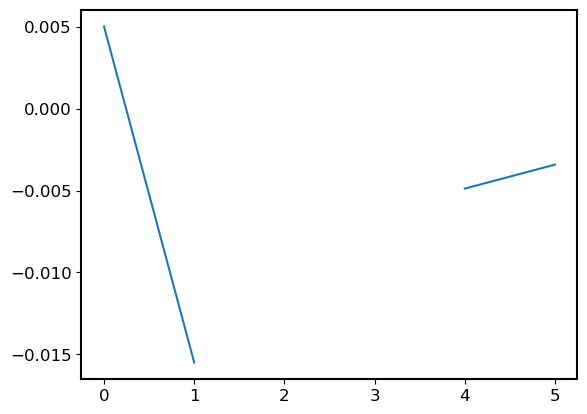

In [6]:
plt.plot(duacs.isel(lat=200).isel(time=0).isel(lon=slice(718,724)).ugos.values)

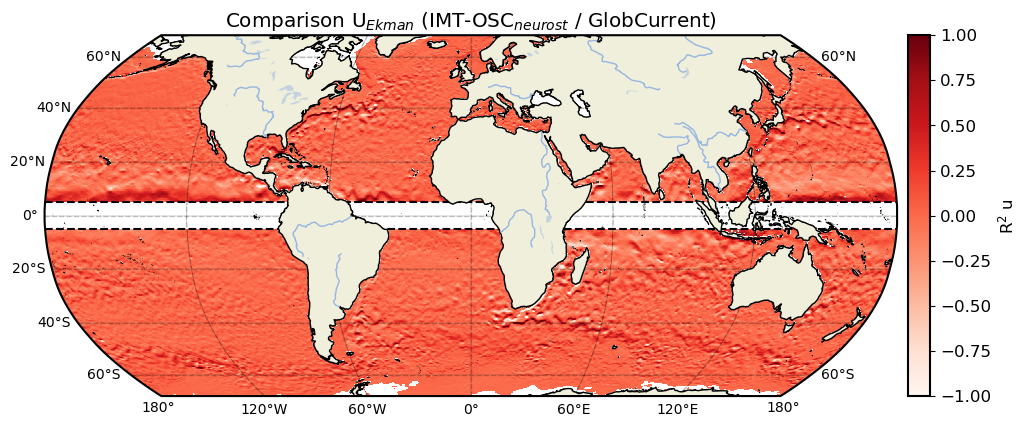

In [7]:
# Remplacement des valeurs à l'indice 716 par cette moyenne
duacs.loc[dict(lon=duacs.lon.isel(lon=720))] = duacs_int.loc[dict(lon=duacs_int.lon.isel(lon=720))]
duacs.loc[dict(lon=duacs.lon.isel(lon=721))] = duacs_int.loc[dict(lon=duacs_int.lon.isel(lon=721))]

plot_uv_map(duacs.ugos.isel(time=1),duacs.lon,duacs.lat,lat_mask=5,vmin=-1,vmax=1,colorbar_title="R$^{2}$ u",title="Comparison U$_{Ekman}$ (IMT-OSC$_{neurost}$ / GlobCurrent)",cmap=plt.cm.Reds)

In [8]:
# U - Ugeo
U_ekman = (imt.ugos - duacs.ugos).compute() #+ diff_mean_u
# Calculer la corrélation le long de l'axe temporel (time)
correlations_u = xr.corr(U_ekman, gc.ue, dim='time')

# U - Ugeo
V_ekman = (imt.vgos - duacs.vgos).compute() #+ diff_mean_v
# Calculer la corrélation le long de l'axe temporel (time)
correlations_v = xr.corr(V_ekman, gc.ve, dim='time')

In [9]:
path_ek_dom="/Odyssey/private/t22picar/plot_article/ekman/ek_dom_mean.nc"
ek_dom_mean = xr.open_dataset(path_ek_dom)
ek_dom_mean = ek_dom_mean.interp(lon=imt.lon,lat=imt.lat,method="linear") #.__xarray_dataarray_variable__.values
# Exemple avec coarsen (bins réguliers de taille 2)
binned_mean = ek_dom_mean.coarsen(lat=5, lon=5, boundary='trim').mean(skipna=True)
binned_mean_np = binned_mean.__xarray_dataarray_variable__.values

In [35]:
import matplotlib.colors as mcolors
hatch_color=mcolors.to_rgba("k")
plt.rcParams['hatch.color'] = hatch_color
plt.rcParams['hatch.linewidth'] = 0.8

/Odyssey/private/t22picar/miniforge3/envs/4dvarnet-daniel/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1642: UserWarning: The following kwargs were not used by contour: 'edgecolor'
  result = super().contourf(*args, **kwargs)


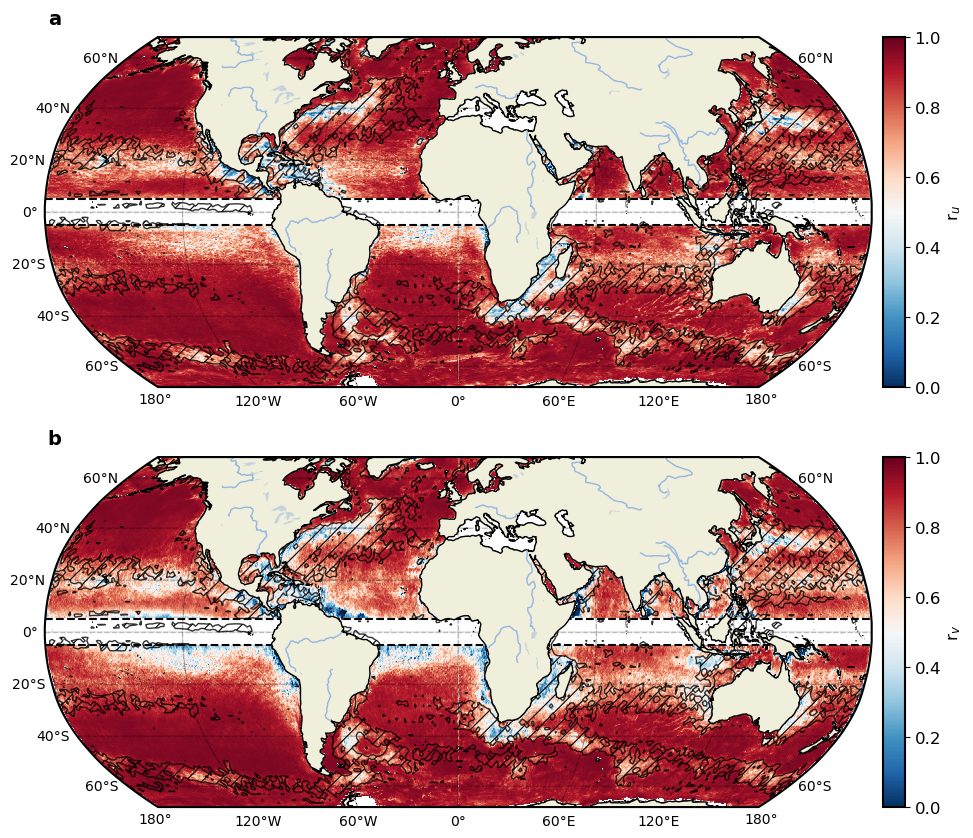

In [37]:
# Compare map 
import cartopy.crs as ccrs
fig, axs = plt.subplots(nrows=2,ncols=1,
                    subplot_kw={'projection': ccrs.Robinson()},
                    figsize=(11*1,5*2))

title = "Comparison U$_{Ekman}$ (IMT-OSC$_{neurost}$ / GlobCurrent)"
title = " "

plot_uv_map(correlations_u,imt.lon,imt.lat,lat_mask=5,vmin=0,vmax=1,colorbar_title="r$_{u}$",title=title,cmap=plt.cm.RdBu_r,fig=fig,axs=axs[0])
axs[0].text(0.02, 1.08, "a", transform=axs[0].transAxes, fontsize=14, fontweight='bold', va='top', ha='right', bbox=dict(facecolor='none', alpha=0.7, edgecolor='none'))
axs[0].contour(binned_mean.lon,binned_mean.lat,binned_mean_np,colors='k',levels=[1],alpha=0.8,linewidths=1,transform=ccrs.PlateCarree())
axs[0].contourf(binned_mean.lon,binned_mean.lat,binned_mean_np, levels=[0, 1], colors=['none'], hatches=['//'],alpha=0,transform=ccrs.PlateCarree())

plot_uv_map(correlations_v,imt.lon,imt.lat,lat_mask=5,vmin=0,vmax=1,colorbar_title="r$_{v}$",cmap=plt.cm.RdBu_r,fig=fig,axs=axs[1])
axs[1].text(0.02, 1.08, "b", transform=axs[1].transAxes, fontsize=14, fontweight='bold', va='top', ha='right', bbox=dict(facecolor='none', alpha=0.7, edgecolor='none'))
axs[1].contour(binned_mean.lon,binned_mean.lat,binned_mean_np,colors='k',levels=[1],alpha=0.8,linewidths=1,transform=ccrs.PlateCarree())
axs[1].contourf(binned_mean.lon,binned_mean.lat,binned_mean_np, levels=[0, 1], colors=['none'], hatches=['//'],edgecolor='grey',alpha=0,transform=ccrs.PlateCarree())
plt.savefig(f"../figures/Figure_ekman_neu.png", dpi = 300,bbox_inches='tight')

In [52]:

def plot_uv_map(uv,lon2D,lat2D,cmap=plt.cm.RdBu_r,vmax=1,vmin=-1,title=None,colorbar_title="norm(U) [m/s]",axs=None,fig=None,colorbar=True,lat_mask=None):

    if not axs:

        fig, axs = plt.subplots(nrows=1,ncols=1,
                            subplot_kw={'projection': ccrs.PlateCarree()},
                            figsize=(11*1,5*1))

    if lat_mask is not None:
        axs.hlines(lat_mask,np.min(lon2D),np.max(lon2D),color='k', alpha=1, linestyle='--')
        axs.hlines(-lat_mask,np.min(lon2D),np.max(lon2D),color='k', alpha=1, linestyle='--')

    if title:
        axs.set_title(title)

    #p0 = plt.pcolormesh(lon2D, lat2D, norm_uv, cmap='jet',vmax=1)
    p0 = axs.pcolormesh(lon2D, lat2D, uv, cmap=cmap,vmax=vmax,vmin=vmin)  

    axs.coastlines(resolution='10m', lw=0.5)
    #axs.add_feature(cfeature.LAND.with_scale('50m'), facecolor='#EEEEEE', edgecolor='face',alpha=1)

    # optional add grid lines
    p0.axes.gridlines(color='black', alpha=0., linestyle='--')

    # draw parallels/meridiens and write labels
    gl = p0.axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                            linewidth=0.2, color='black', alpha=0.8, linestyle='--')
    # adjust labels to taste
    gl.top_labels = False
    gl.right_labels = False
    gl.bottom_labels = True
    gl.left_labels = True
    #gl.ylocator = mticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])
    #gl.xlocator = mticker.FixedLocator([-180, -60, 0,  60, 180])
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}

    #get size and extent of axes:
    axpos = axs.get_position()
    pos_x = axpos.x0+axpos.width + 0.01# + 0.25*axpos.width
    pos_y = axpos.y0
    cax_width = 0.02
    cax_height = axpos.height

    if colorbar:
        #create new axes where the colorbar should go.
        #it should be next to the original axes and have the same height!
        pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])
        cbar=plt.colorbar(p0, cax=pos_cax)
        cbar.set_label(colorbar_title)

    #cax = fig.add_axes([0.92, 0.37, 0.02, 0.25])
    #cbar = fig.colorbar(p0, cax=axs, orientation='vertical')
    #cax.set_ylabel('Number of data', fontweight='bold')


    
def plot_map_zoom_only(var,lon,lat,title=None,vmax=None,vmin=None,colorbar_label=None,axs=None,fig=None,zoom_extent=[-20, 0, 40, 60],cmap='RdBu_r',zoom_ax = [0.25, 0.10, 0.5, 0.5],lat_mask=5):

    if not axs:
        fig, axs = plt.subplots(nrows=1,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(11*1,7.5*1))
        #p0 = plt.pcolormesh(lon2D, lat2D, norm_uv, cmap='jet',vmax=1)
    #vmax_glob=np.nanmax(var)
    #vmin_glob=np.nanmin(var)

        # Ajouter un zoom sur une région spécifique
    axs.set_extent(zoom_extent, crs=ccrs.PlateCarree())  # Exemple de zoom sur l'Europe
    axs.coastlines()

    axs.hlines(lat_mask,-180,180,color='k', alpha=1, linestyle='--')
    axs.hlines(-lat_mask,-180,180,color='k', alpha=1, linestyle='--')

    lon_mg,lat_mg = np.meshgrid(lon,lat)
    var_f = np.where(lat_mg > zoom_extent[2] , var, np.nan)
    var_f = np.where(lat_mg < zoom_extent[3] , var_f, np.nan)
    var_f = np.where(lon_mg < zoom_extent[1] , var_f, np.nan)
    var_f = np.where(lon_mg > zoom_extent[0] , var_f, np.nan)

    if not(vmax):
        vmax=np.nanmax(var_f)
        vmin=np.nanmin(var_f)

    contour_zoom = axs.pcolormesh(lon, lat, var_f, cmap=cmap,transform=ccrs.PlateCarree(),vmax=vmax,vmin=vmin)

    if title:
        axs.set_title(title)

    axs.coastlines(resolution='10m', lw=0.5)
    #axs.add_feature(cfeature.LAND.with_scale('50m'), facecolor='#EEEEEE', edgecolor='face',alpha=1)

    # optional add grid lines
    contour_zoom.axes.gridlines(color='black', alpha=0., linestyle='--')

    # draw parallels/meridiens and write labels
    gl = contour_zoom.axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                            linewidth=0.1, color='black', alpha=0.5, linestyle='--')
    # adjust labels to taste
    gl.top_labels = True
    gl.right_labels = False
    gl.bottom_labels = False
    gl.left_labels = True
    #gl.xlabels_bottom = False
    gl.ylocator = mticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])
    gl.xlocator = mticker.FixedLocator([-180, -60, 0,  60, 180])
    #gl.xformatter = LONGITUDE_FORMATTER
    #gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}



    #get size and extent of axes:
    axpos = axs.get_position()
    pos_x = axpos.x0+axpos.width + 0.01# + 0.25*axpos.width
    pos_y = axpos.y0
    cax_width = 0.02
    cax_height = axpos.height
    #create new axes where the colorbar should go.
    #it should be next to the original axes and have the same height!
    pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])
    cbar=plt.colorbar(contour_zoom, cax=pos_cax)
    if colorbar_label:
        cbar.set_label(colorbar_label)


Correction mean current

In [ ]:
# Mean current
duacs_mean = duacs.mean(dim='time').compute()
imt_mean = imt.mean(dim='time').compute()

diff_mean_u =  imt_mean.ugos - duacs_mean.ugos
diff_mean_v =  imt_mean.vgos - duacs_mean.vgos

/Odyssey/private/t22picar/miniforge3/envs/4dvarnet-daniel/lib/python3.10/site-packages/dask/array/numpy_compat.py:51: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/Odyssey/private/t22picar/miniforge3/envs/4dvarnet-daniel/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/Odyssey/private/t22picar/miniforge3/envs/4dvarnet-daniel/lib/python3.10/site-packages/dask/array/numpy_compat.py:51: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/Odyssey/private/t22picar/miniforge3/envs/4dvarnet-daniel/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/Odyssey/private/t22picar/miniforge3/envs/4dvarnet-daniel/lib/python3.10/site-packages/dask/array/numpy_compat.py:51: RuntimeWarning: invalid value encountered in divide
  x = 

In [ ]:
# Compare map 
import cartopy.crs as ccrs
fig, axs = plt.subplots(nrows=2,ncols=1,
                    subplot_kw={'projection': ccrs.PlateCarree()},
                    figsize=(11*1,5*2))

plot_uv_map(diff_mean_u,imt.lon,imt.lat,lat_mask=None,vmin=-0.2,vmax=0.2,colorbar_title="R$^{2}$ u",title="Comparison U$_{Ekman}$ (IMT-OSC$_{duacs}$ / GlobCurrent)",cmap=plt.cm.RdBu_r,fig=fig,axs=axs[0])
axs[0].text(0.02, 1.08, "a", transform=axs[0].transAxes, fontsize=14, fontweight='bold', va='top', ha='right', bbox=dict(facecolor='none', alpha=0.7, edgecolor='none'))
plot_uv_map(diff_mean_v,imt.lon,imt.lat,lat_mask=None,vmin=-0.2,vmax=0.2,colorbar_title="R$^{2}$ v",cmap=plt.cm.RdBu_r,fig=fig,axs=axs[1])
axs[1].text(0.02, 1.08, "b", transform=axs[1].transAxes, fontsize=14, fontweight='bold', va='top', ha='right', bbox=dict(facecolor='none', alpha=0.7, edgecolor='none'))

In [12]:
# U - Ugeo
U_ekman = imt.ugos - duacs.ugos - diff_mean_u
# Calculer la corrélation le long de l'axe temporel (time)
correlations_u = xr.corr(U_ekman, gc.ue, dim='time').compute()

# U - Ugeo
V_ekman = imt.vgos - duacs.vgos - diff_mean_v
# Calculer la corrélation le long de l'axe temporel (time)
correlations_v = xr.corr(V_ekman, gc.ve, dim='time').compute()

Text(0.02, 1.08, 'b')

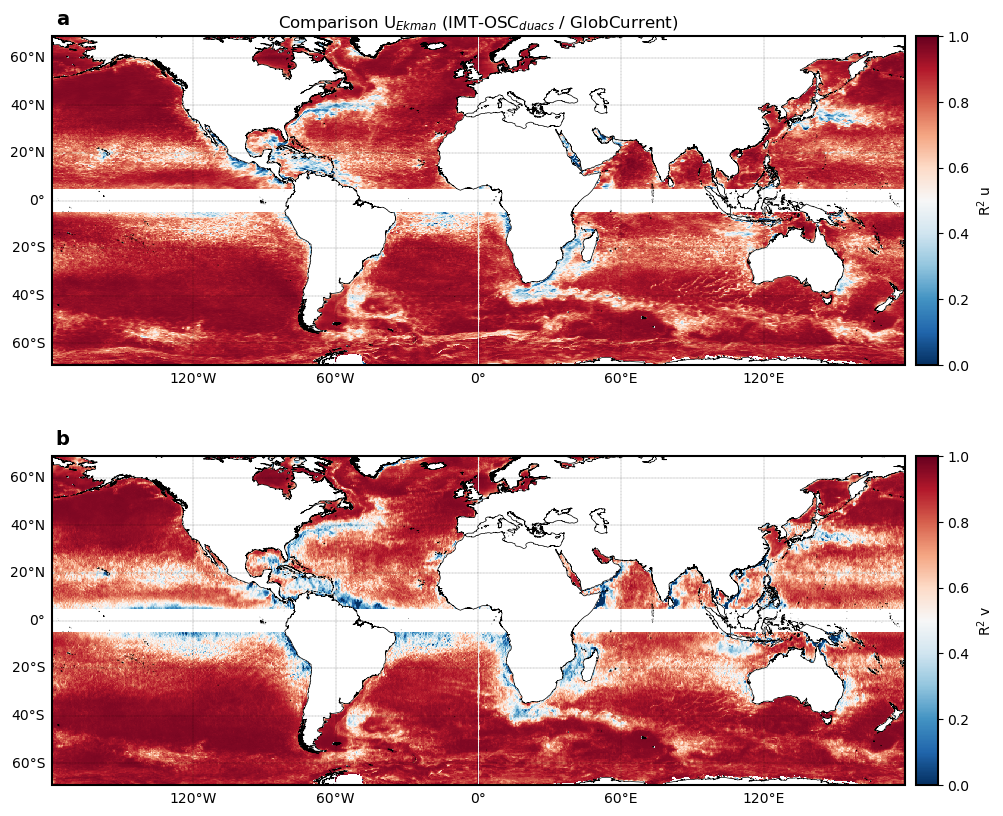

In [13]:

# Compare map 
import cartopy.crs as ccrs
fig, axs = plt.subplots(nrows=2,ncols=1,
                    subplot_kw={'projection': ccrs.PlateCarree()},
                    figsize=(11*1,5*2))

plot_uv_map(correlations_u,imt.lon,imt.lat,lat_mask=None,vmin=0,vmax=1,colorbar_title="R$^{2}$ u",title="Comparison U$_{Ekman}$ (IMT-OSC$_{duacs}$ / GlobCurrent)",cmap=plt.cm.RdBu_r,fig=fig,axs=axs[0])
axs[0].text(0.02, 1.08, "a", transform=axs[0].transAxes, fontsize=14, fontweight='bold', va='top', ha='right', bbox=dict(facecolor='none', alpha=0.7, edgecolor='none'))
plot_uv_map(correlations_v,imt.lon,imt.lat,lat_mask=None,vmin=0,vmax=1,colorbar_title="R$^{2}$ v",cmap=plt.cm.RdBu_r,fig=fig,axs=axs[1])
axs[1].text(0.02, 1.08, "b", transform=axs[1].transAxes, fontsize=14, fontweight='bold', va='top', ha='right', bbox=dict(facecolor='none', alpha=0.7, edgecolor='none'))
#plt.savefig(f"../figures/Figure_ekman.png", dpi = 300,bbox_inches='tight')